In [304]:
import numpy as np

EPS = np.finfo(np.float32).eps

def loss(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)


def loss_d(y_true, y_pred):
    return 2 * y_pred[0] - 2 * y_true


def sigm_fun(x):
    return 1 / (1 + np.exp(-x))


def sigm_d(sigm_val):
    return sigm_val * (1 - sigm_val)


def relu(x):
    return 0.01 * x if x < 0 else x


def relu_d(relu_val):
    return 0.01 if relu_val <= 0 else 1

def linear(x):
    return x
def linear_d(linear_val):
    return 1

def tanh(x):
    return np.tanh(x)

def tanh_d(tanh_val):
    return 1 - tanh_val**2

def softmax(x):
    _x = x.copy()
    _x-=np.max(x)
    return (np.exp(_x)/(np.exp(_x).sum())).tolist()

def softmax_d(softmax_val, y_ind):
    s_y = softmax_val[y_ind]
    return [s_y*(1-s) if i == y_ind else -s * s_y for i, s in enumerate(softmax_val)]


def cross_entropy_loss(y_true, y_pred):
    return -(np.log(np.array(y_pred) + EPS)*np.array(y_true)).sum()


def cross_entropy_loss_d(y_true, y_pred):
    return -1/((np.array(y_pred)*np.array(y_true)).sum() + EPS)


class Neuron:
    def __init__(self, rng, input_dim, activation_f, activation_f_d):
        self.activation_f = activation_f
        self.activation_f_d = activation_f_d
        weight_list = []
        for i in range(input_dim):
            weight_list.append(rng.uniform(-1, 1) * 0.1)
        self.weights = np.asarray(weight_list)
        self.b = rng.uniform(-1, 1)
        self.b_grad = 0
        self.w_grad = np.zeros(input_dim)
        self.out_grad = 0

    def work(self, inputs):
        self.x = np.array(inputs)
        sum = np.sum(inputs * self.weights) + self.b

        self.output = self.activation_f(sum)
        return self.output

    def x_grad(self, i):
        return self.out_grad * self.activation_f_d(self.output) * self.weights[i]

    def generate_param_grad(self):
        self.w_grad = self.out_grad * self.activation_f_d(self.output) * self.x
        self.b_grad = self.out_grad * self.activation_f_d(self.output)

    def update_weights(self, errors, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * errors[i] * self.x[i]


class NeuralNet:
    def __init__(
        self,
        number_of_neurons_in_layer,
        hidden_layers,
        input_dim,
        number_of_outputs=1,
        seed=10,
        activation_f="sigmoid",
        out_activation_f="linear",
        loss_f="RSS"
    ):
        if loss_f=="RSS":
            self.loss_f=loss
            self.loss_f_d=loss_d
        elif loss_f == "crossentropy":
            self.loss_f=cross_entropy_loss
            self.loss_f_d=cross_entropy_loss_d
        else:
            print("Allowed loss_f values are {'RSS', 'crossentropy'}")
            return

        if out_activation_f == "linear":
            self.out_activation_f = linear
            self.out_activation_f_d = linear_d
        elif out_activation_f == "softmax":
            self.out_activation_f = softmax
            self.out_activation_f_d = softmax
        else:
            print("Allowed out_activation_f values are {'linear', 'softmax'}")
            return

        if activation_f == "sigmoid":
            act_f = sigm_fun
            act_f_d = sigm_d
        elif activation_f == "relu":
            act_f = relu
            act_f_d = relu_d
        elif activation_f == "tanh":
            act_f = tanh
            act_f_d = tanh_d
        else:
            print("Allowed activation_function values are {'sigmoid', 'relu', 'tanh'}")
            return

        self.rng = np.random.default_rng(seed)
        self.layers = []
        self.neurons: list[Neuron] = []
        layer_1 = [
            Neuron(self.rng, input_dim, act_f, act_f_d)
            for _ in range(number_of_neurons_in_layer)
        ]
        self.layers.append(layer_1)
        self.neurons.extend(layer_1)
        for i in range(hidden_layers - 1):
            current_layer = [
                Neuron(self.rng, number_of_neurons_in_layer, act_f, act_f_d)
                for _ in range(number_of_neurons_in_layer)
            ]
            self.neurons.extend(current_layer)
            self.layers.append(current_layer)
        output_layer = []
        for i in range(number_of_outputs):
            output_neuron = Neuron(
                self.rng,
                number_of_neurons_in_layer,
                activation_f=linear,
                activation_f_d=linear_d
            )
            output_layer.append(output_neuron)
            self.neurons.append(output_neuron)
        self.layers.append(output_layer)

    def predict(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        return self.out_activation_f(outputs)

    def backprop_single_input(self, input, y_true):
        y_pred = self.predict(input)
        error = self.loss_f(y_true, y_pred)
        error_d = self.loss_f_d(y_pred=y_pred, y_true=y_true)
        softmax_d_val = [1 for i in range(len(y_pred))]
        if self.out_activation_f == softmax:
            y_true_ind = y_true.tolist().index(1)
            softmax_d_val = softmax_d(y_pred, y_true_ind)
        output_layer = self.layers[-1]
        for i, output_neuron in enumerate(output_layer):
            output_neuron.out_grad = error_d * softmax_d_val[i]
            output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
            next_layer = layer
        return error

    def train(
        self, X, Y, learning_rate=0.05, epochs=50, print_logs=False, batch_size=50, momentum=0.9
    ):
        n = min(batch_size, len(X))
        prev_grad = [(0., 0.) for neuron in self.neurons]
        alpha = momentum
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            batch_ind = self.rng.integers(low=0, high=len(X), size=n)
            for x, y in zip(X[batch_ind], Y[batch_ind]):
                tot_error += self.backprop_single_input(x, y)
                tot_grad = [
                    (grad[0] + neuron.w_grad, grad[1] + neuron.b_grad)
                    for grad, neuron in zip(tot_grad, self.neurons)
                ]
            tot_error = tot_error / n
            prev_grad = [(tot[0]/n + alpha * prev[0],tot[1]/n + alpha * prev[1] ) for tot, prev in zip(tot_grad, prev_grad)]
            for grad, neuron in zip(prev_grad, self.neurons):
                neuron.weights -= grad[0] * learning_rate
                neuron.b -= grad[1] * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")


def exportNeuralNet(nn: NeuralNet, path):
    with open(path, 'w') as file:
        file.write(f"{len(nn.layers)}\n")
        for layer in nn.layers:
            for neuron in layer:
                file.write(','.join(neuron.weights.astype(str)))
                file.write(';')
                file.write(f"{neuron.b}")
                file.write('\n')
            file.write("|\n")
def importNeuralNetWeights(nn: NeuralNet, path):
    with open(path, 'r') as file:
        num_layers = int(file.readline().rstrip())
        layers = []
        current_layer = []
        for line in file:
            line = line.rstrip()
            if len(layers) == num_layers: break
            if line == '|':
                layers.append(current_layer)
                current_layer = []
                continue
            neuron_data = line.split(';')
            weights = np.fromstring(neuron_data[0], dtype=float, sep=',')
            b = float(neuron_data[1])
            current_layer.append((weights,b))
        for neurons, layer_params in zip(nn.layers, layers):
            for neuron, neuron_params in zip(neurons, layer_params):
                neuron.weights = neuron_params[0]
                neuron.b = neuron_params[1]

In [93]:
import math

def evaluate_model_regre(model, X, Y):
    Y_pred = [model.predict(x) for x in X]
    MSE = sum([(y_pred - y)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)

In [94]:
def scale(X, min, max):
    return (X.astype(float) - min) / (max - min)

# Mnist

(60000, 28, 28)
(60000,)
0


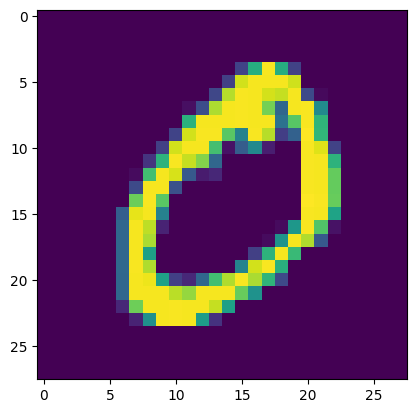

In [106]:
from mnist_reader import read_mnist_data, plot_img
images, labels = read_mnist_data(img_path="./mnist/train-images.idx3-ubyte", labels_path="./mnist/train-labels.idx1-ubyte")
print(images.shape)
print(labels.shape)
print(labels[1])
plot_img(images[1]);

## Training


In [275]:
from sklearn.preprocessing import OneHotEncoder
from mnist_reader import read_mnist_data, plot_img

images_traing, labels_train = read_mnist_data(img_path="./mnist/train-images.idx3-ubyte", labels_path="./mnist/train-labels.idx1-ubyte")
images_test, labels_test = read_mnist_data(img_path="./mnist/t10k-images.idx3-ubyte", labels_path="./mnist/t10k-labels.idx1-ubyte")

enc = OneHotEncoder()
enc.fit(labels_train.reshape(-1,1))

Y_train = enc.transform(labels_train.reshape(-1,1)).toarray()
X_train = images_traing.reshape(60000,28*28)/255.0 - 0.5
Y_test = enc.transform(labels_test.reshape(-1,1)).toarray()
X_test = images_test.reshape(10000,28*28)/255.0 - 0.5

In [300]:

classifier = NeuralNet(
    number_of_neurons_in_layer=100,
    hidden_layers=3,
    input_dim=28*28,
    number_of_outputs=10,
    activation_f='relu',
    loss_f='crossentropy',
    out_activation_f='softmax',
    seed=10
)
classifier.train(X_train, Y_train, learning_rate=0.005, epochs=10000, batch_size=32, momentum=0.9, print_logs=True)

Epoch: 0, mean loss: 2.4302597275459994
Epoch: 1, mean loss: 2.6881764351825566
Epoch: 2, mean loss: 2.54740308621897
Epoch: 3, mean loss: 2.3609596809583127
Epoch: 4, mean loss: 2.382442299202247
Epoch: 5, mean loss: 2.4898329001221713
Epoch: 6, mean loss: 2.567542039847478
Epoch: 7, mean loss: 2.247079576195917
Epoch: 8, mean loss: 2.2979386426785986
Epoch: 9, mean loss: 2.6086511406602644
Epoch: 10, mean loss: 2.3605540687765436
Epoch: 11, mean loss: 2.44014678025075
Epoch: 12, mean loss: 2.4826157817283194
Epoch: 13, mean loss: 2.5295368044669897
Epoch: 14, mean loss: 2.234373785089416
Epoch: 15, mean loss: 2.368163711306042
Epoch: 16, mean loss: 2.2631055288373836
Epoch: 17, mean loss: 2.289811154258806
Epoch: 18, mean loss: 2.286799158118613
Epoch: 19, mean loss: 2.257027961971955
Epoch: 20, mean loss: 2.3107679533911947
Epoch: 21, mean loss: 2.2845063968179233
Epoch: 22, mean loss: 2.327148591449179
Epoch: 23, mean loss: 2.3222378808283755
Epoch: 24, mean loss: 2.306169511748789

In [294]:
def calculate_accuracy(nn: NeuralNet, X, Y):
    Y_pred = [nn.predict(x) for x in X]
    Y_pred = [y.index(max(y)) for y in Y_pred]
    return sum([1 if y == y_pred else 0 for y,y_pred in zip(Y.argmax(axis=1),Y_pred)])/len(Y)

In [301]:
test_accuracy = calculate_accuracy(classifier, X_test, Y_test)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9702


In [305]:
classifier = NeuralNet(
    number_of_neurons_in_layer=100,
    hidden_layers=3,
    input_dim=28*28,
    number_of_outputs=10,
    activation_f='relu',
    loss_f='crossentropy',
    out_activation_f='softmax',
    seed=10
)

importNeuralNetWeights(classifier, "97.txt")
test_accuracy = calculate_accuracy(classifier, X_test, Y_test)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9702


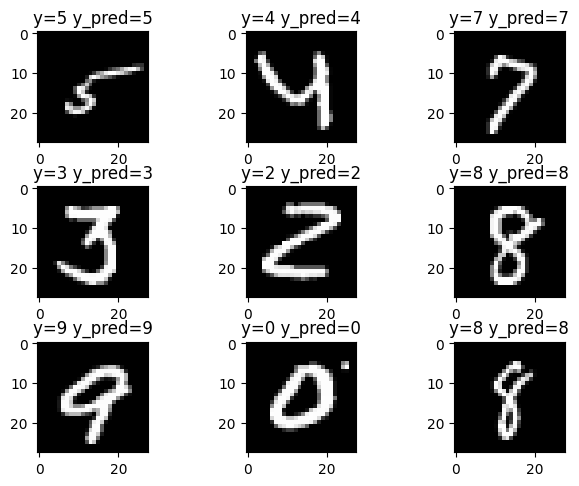

In [346]:
from matplotlib.pyplot import subplots

fig, axis = subplots(nrows=3, ncols=3)
fig.tight_layout()
for ax in axis.reshape(-1):
    ind = np.random.randint(low=0, high = 10000)
    ax.imshow(images_test[ind], cmap='gray')
    predicted_label = np.array(classifier.predict(X_test[ind])).argmax()
    ax.set_title(f"y={labels_test[ind]} y_pred={predicted_label}")